# Label Models
Demonstrates how to use label models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh

# !bash ./scripts/download_wrench_datasets.sh

In [5]:
from examples.utils import load_wrench_dataset, MetricsUtil

Choose your dataset here

In [6]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "youtube"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

c:\Users\liamt\Repos\flippers\flippers\_core\_core.py:151: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.5333333333333333, 0.4666666666666667]

In [8]:
polarities

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 0], dtype=int64)

In [9]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matches,conflicts
0,1,0.199,1.0,0.186,0.156,0.110
1,1,0.127,1.0,0.108,0.080,0.068
2,1,0.119,1.0,0.102,0.040,0.083
3,1,0.112,1.0,0.110,0.102,0.057
4,0,0.142,1.0,0.112,0.093,0.044
5,1,0.234,1.0,0.133,0.095,0.086
6,0,0.226,1.0,0.144,0.079,0.074
7,0,0.083,1.0,0.061,0.045,0.025
8,0,0.035,1.0,0.032,0.031,0.005
9,0,0.358,1.0,0.262,0.137,0.160


Scoring utils:

In [10]:
y_test = test["label"].astype(int).values

In [11]:
Metrics = MetricsUtil(y_test, L_test)

# Training Label Models

## Majority Vote Model

In [12]:
from flippers.models import Voter

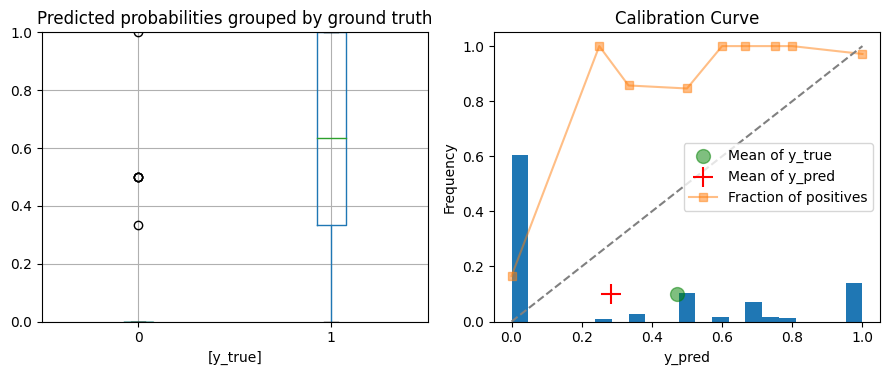

{'F1': 0.692,
 'Average_Precision': 0.861,
 'AUC': 0.879,
 'Accuracy': 0.776,
 'Balanced_Accuracy': 0.763}

In [13]:
preds_vote = Voter(polarities)
Metrics.score(preds_vote, name="MV")

## `flippers`' Snorkel Model

Training a Label Model with Flippers is very simple:

In [14]:
from flippers.models import SnorkelModel

In [15]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(
    L_train,
    learning_rate=5e-3,
    num_epochs=50,
    k=1e-2,
    verbose=True,
)

Epoch 50/50 | Loss 0.0410: 100%|██████████| 50/50 [00:00<00:00, 387.30it/s]


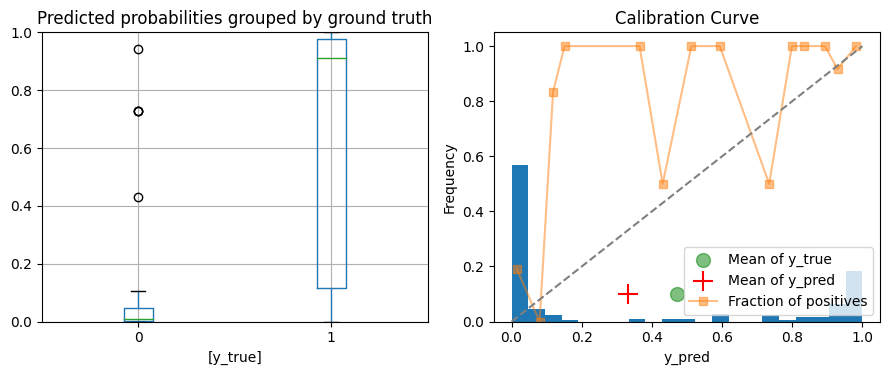

{'F1': 0.804,
 'Average_Precision': 0.892,
 'AUC': 0.853,
 'Accuracy': 0.84,
 'Balanced_Accuracy': 0.832}

In [16]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
Metrics.score(m, name="flippers")

# VAE

In [17]:
from examples.Experiments._vae import WeakLabelVAE

Epoch [21/21]: 100%|██████████| 21/21 [00:03<00:00,  6.05it/s, Loss=11.0]


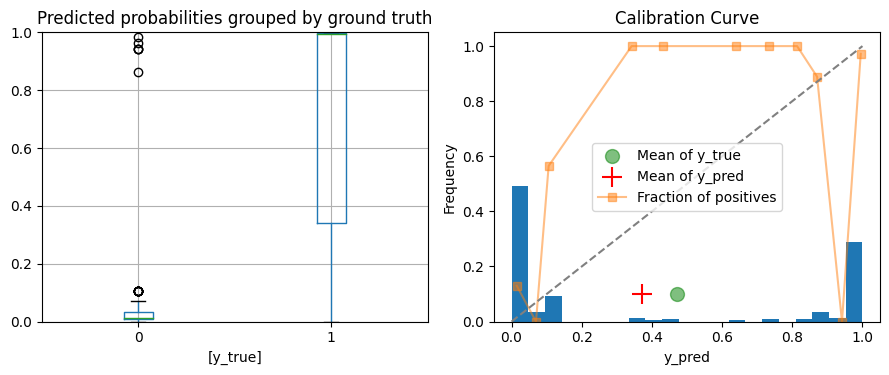

{'F1': 0.802, 'Average_Precision': 0.91, 'AUC': 0.877, 'Accuracy': 0.836, 'Balanced_Accuracy': 0.829}


In [18]:
m = WeakLabelVAE(polarities=polarities, class_balances=class_balances, latent_dim=0)
m.fit(L_train, lr=1e-4, num_batches=1000, nudge=1)
print(Metrics.score(m, name="WeakLabelVAE"))